# Feedback

## Load Modules

In [3]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ", file_dir)

parent_dir = file_dir.parent
print(parent_dir)

sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [35]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import clean_up_categoricals, calc_col_partitioned, desc_col

from pa_lib.vis import boxplot_histogram

from pa_lib.file import project_dir, load_bin, load_csv, load_xlsx
from pa_lib.util import cap_words
import os, fnmatch

# Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job


pd.set_option("display.max_rows", min(raw_feedback.shape[0] + 1, 3000))
pd.set_option("display.max_colwidth", 500)

from matplotlib.pyplot import show
import altair as alt

alt.data_transformers.disable_max_rows()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DataTransformerRegistry.enable('default')

https://stackabuse.com/python-list-files-in-a-directory/

# Load Data

## Load Feedback

In [5]:
def load_feedback(sales_folder):
    sales_subfolder = os.listdir(sales_folder)
    pattern = "EK_LIST*.xlsx"

    container_df = pd.DataFrame()
    columns_in_xlsx = [
        "Gepard-Nr. Endkunde",
        "Endkunde",
        "Chance",
        "Feedback - bitte auswählen",
        "falls nicht hilfreich, bitte hier einen kurzen Kommentar angeben - entweder pro Zeile oder für die Gesamt-Liste",
    ]
    rename_columns = ["Endkunde_NR", "Endkunde", "Prob_1", "Feedback", "Kommentar"]

    for kw_folder in sales_subfolder:

        if kw_folder >= "2019_07_15":  # Begin of automatisation

            all_files_list = os.listdir(sales_folder / kw_folder)

            for file in all_files_list:

                if fnmatch.fnmatch(file, pattern):
                    # print(f"{kw_folder}  ---- {file}") # Check!
                    vkber_df = load_xlsx(sales_folder / kw_folder / file).loc[
                        :, columns_in_xlsx
                    ]  # .iloc[:,[0,1,-3,-2,-1]])

                    vkber_df.columns = rename_columns

                    vkber_df.loc[:, "folder"] = kw_folder
                    vkber_df.loc[:, "file_name"] = file

                    container_df = container_df.append(vkber_df, ignore_index=False)

    container_df.loc[:, "Kuerzel"] = container_df.loc[:, "file_name"].apply(
        lambda x: x[19:22]
    )

    # Remove all redundant rows:
    feedback_exists = (
        #         (  # Feedback or Kommentar exists
        #             ~container_df.loc[:, "Feedback"].isna()
        #             | ~container_df.loc[:, "Kommentar"].isna()
        #         )
        #         &
        ~container_df.loc[:, "Endkunde_NR"].isna()  # Endkunde_NR must exist
    )
    container_df.loc[:, "Feedback"] = container_df.Feedback.fillna("untouched")

    row_select = ~container_df.Kommentar.isna() & container_df.Feedback.isin(
        {"untouched"}
    )

    container_df.loc[row_select, "Feedback"] = "nur kommentiert"

    return container_df.loc[feedback_exists, :].sort_values(
        ["folder", "file_name"], ascending=[False, True]
    )

In [6]:
sales_folder = Path('P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics')
print(sales_folder)

P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics


In [7]:
%%capture
raw_feedback = load_feedback(sales_folder=sales_folder)

## Load VB Information

In [8]:
request_job(job_name="vkber_prepare.py", current="Today")  # output: vkber_data.csv

with project_dir("vkprog"):
    vb_list = load_csv("vkber_data.csv", sep=",", encoding="UTF-8")
    
display(vb_list.head(10))
display(desc_col(vb_list))

09:36:01 [INFO] [ipykernel_launcher.py] requests 'vkber_prepare.py'
09:36:01 [INFO] [ipykernel_launcher.py]: Not running job 'vkber_prepare.py': result is current ('Today') from 2020-01-13 09:13:04.364966.
09:36:01 [INFO] Started loading CSV file ...
09:36:01 [INFO] Reading from file C:\Users\stc\data\vkprog\vkber_data.csv
09:36:01 [INFO] ... finished loading CSV file in 0.0s (0.0s CPU)


,MA_ID,KOMBI_NAME,E_MAIL,KURZZEICHEN,FUNKTION,KAM
0,125,Schnyder Bernhard,bernhard.schnyder@apgsga.ch,ABS,Key Account Management,True
1,15505,Coralic Alma,alma.coralic@apgsga.ch,ACO,Verkaufsberatung Ost Aussendienst,False
2,155,Steltzlen Andreas,andreas.steltzlen@apgsga.ch,AST,Leitung Verkaufsberatung Bern Mitte,False
3,99,Baumann Marcel,marcel.baumann@apgsga.ch,BAM,Leitung Key Account Management,True
4,15583,Borri Barbara,barbara.borri@apgsga.ch,BBO,Sales Management Airport Advertising,True
5,16145,Djoungong Bruno,bruno.djoungong@apgsga.ch,BDJ,Conseil de vente Romandie Service externe,False
6,16071,Baumgartner Bernhard,bernhard.baumgartner@apgsga.ch,BEB,Verkaufsberatung Bern Mitte Aussendienst,False
7,15130,Grandjean Benjamin,benjamin.grandjean@apgsga.ch,BEG,Key Account Management,True
8,371,Bonotto Massimo,massimo.bonotto@apgsga.ch,BON,Leitung Verkaufsberatung Südost,False
9,15922,Bratschi Raphael,raphael.bratschi@apgsga.ch,BRA,Leitung aymo mobile targeting,False


,DTYPE,NULLS,UNIQUE
MA_ID,int64,0/86,86
KOMBI_NAME,object,0/86,86
E_MAIL,object,0/86,86
KURZZEICHEN,object,0/86,86
FUNKTION,object,0/86,47
KAM,bool,0/86,2


# Feedback Count

In [13]:
raw_feedback.sample(5)

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name,Kuerzel
7,129814,Vabeene Shoe Manufacture,7.7,untouched,NaN,2019_10_21,EK_LIST_2W_KOMPAKT_DCI.xlsx,DCI
18,509868,fitnessplus basel ag,3.2,untouched,NaN,2019_11_04,EK_LIST_2W_KOMPAKT_RPO.xlsx,RPO
6,595400,International School of Ticino SA,5.5,nicht hilfreich,scuola chiusa ricontattare a novembre,2019_10_21,EK_LIST_2W_KOMPAKT_TRA.xlsx,TRA
8,625248,Association des commerçants,3.1,untouched,NaN,2019_08_12,EK_LIST_2W_KOMPAKT_CKT.xlsx,CKT
17,594430,Elektrizitätswerk des Kantons Zürich,1.3,untouched,NaN,2019_07_29,EK_LIST_2W_KOMPAKT_PKL.xlsx,PKL


# Counts: Deployed Leads

In [34]:
(raw_feedback.groupby("folder").agg({"Endkunde_NR": "count"})).tail(5)

,Endkunde_NR
folder,
2019_11_18,646
2019_12_02,712
2019_12_16,728
2019_12_30,723
2020_01_13,740


Text(0, 0.5, 'Anzahl')

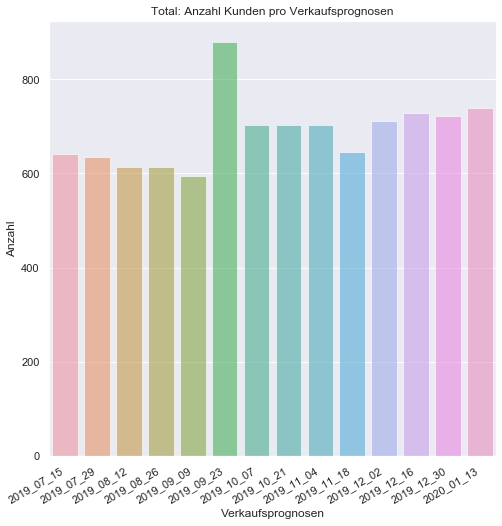

In [15]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
ax = (
    sns.countplot(
        x     = "folder",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        #order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )

plt.title("Total: Anzahl Kunden pro Verkaufsprognosen")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

## Count Distribution by Feedback

Text(0, 0.5, 'Anzahl')

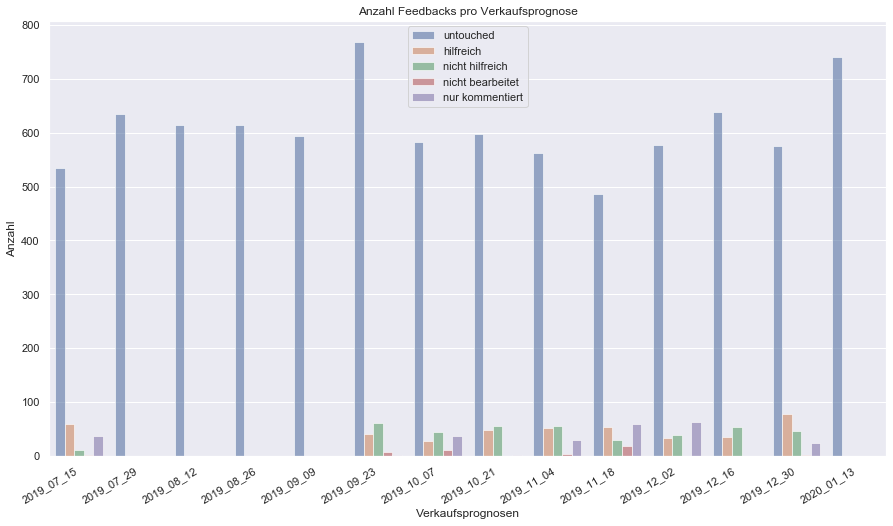

In [36]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "folder",
        hue   = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
plt.legend(loc='best')

plt.title("Anzahl Feedbacks pro Verkaufsprognose")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

In [18]:
raw_feedback.loc[:, "test"] = 1

alt.Chart(
    # raw_feedback.loc[raw_feedback.folder.isin(last_vkrpogs), :]
    raw_feedback
).mark_bar(opacity=0.6).encode(
    y=alt.X("sum(test)", stack="normalize", title="Anteil",),
    x=alt.Y("folder",title="Verkaufsprognose"),
    color="Feedback",
    order=alt.Order("Feedback",sort="ascending")
).properties(
    height=500, width=500
)


alt.Chart(...)

In [42]:
last_vkrpogs = set(sorted(list(set(raw_feedback.folder)), reverse=True)[:4])

display(last_vkrpogs)

{'2019_12_02', '2019_12_16', '2019_12_30', '2020_01_13'}

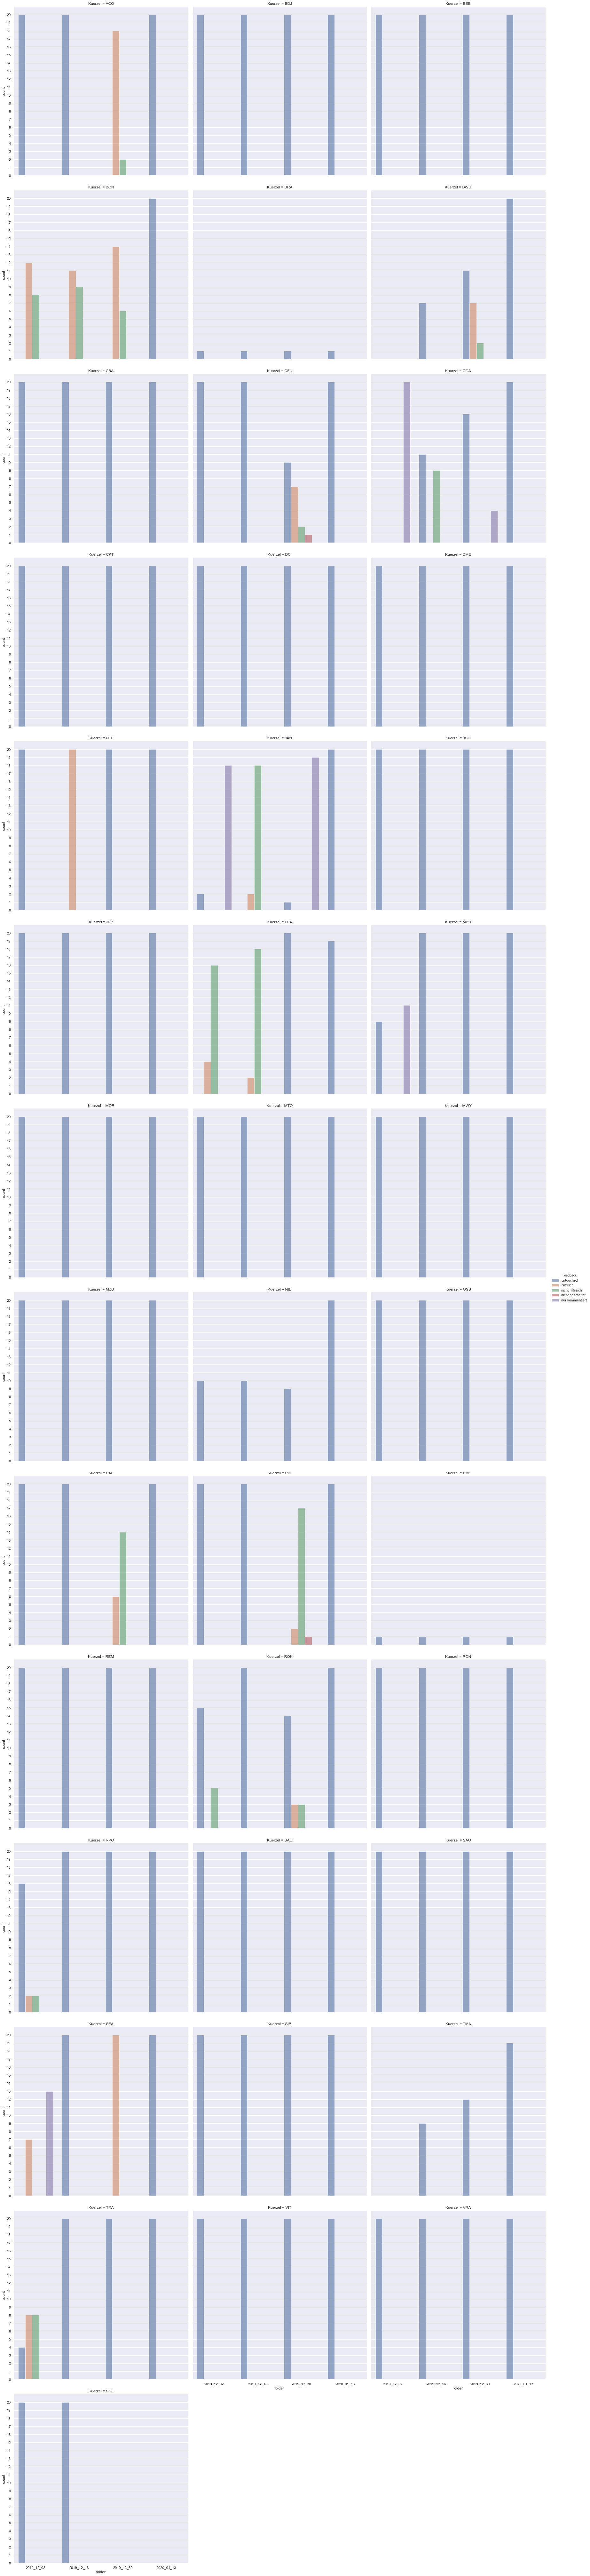

In [43]:
yticks = range(0, 21)

g = sns.catplot(
    x="folder",
    hue="Feedback",
    col="Kuerzel",
    data=raw_feedback.loc[raw_feedback.folder.isin(last_vkrpogs), :],
    kind="count",
    height=8,
    aspect=1,
    col_wrap=3,
    alpha=0.6,
)

g.set(yticks=yticks)

# plt.xticks(rotation=30, ha="right")

## Report: Bearbeitungsgrad pro VB

Text(0.5, 0, 'Anzahl')

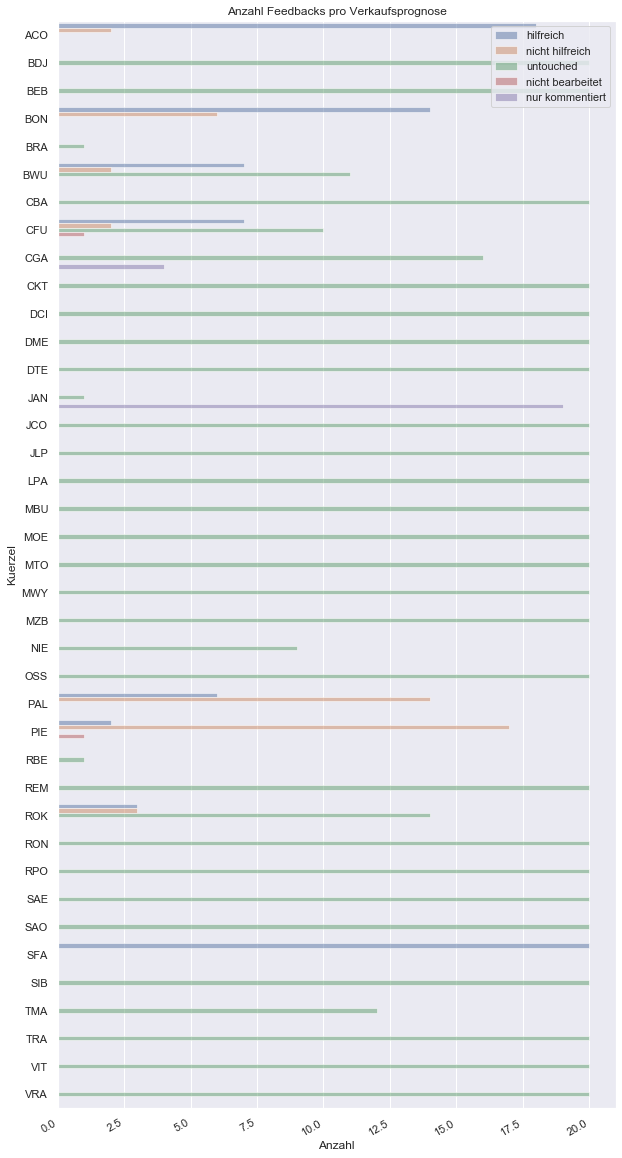

In [20]:
row_select = raw_feedback.folder.isin({"2019_12_30"})

sns.set(style="darkgrid")
plt.figure(figsize=(10, 20))

ax = sns.countplot(
    y="Kuerzel", hue="Feedback", data=raw_feedback.loc[row_select, :], alpha=0.5
)
plt.legend(loc="best")

plt.title("Anzahl Feedbacks pro Verkaufsprognose")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Kuerzel")
plt.xlabel("Anzahl")

In [40]:
def lazy_replacer(string, to_replace, replaced_with):
    for x in to_replace:
        string = string.replace(x, replaced_with)
    return string


kuerzel_bearbeitung = (
    pd.pivot_table(
        raw_feedback,
        values="Endkunde_NR",
        index=["Kuerzel", "Feedback", "folder"],
        aggfunc="count",
    )
    .reset_index()
    .rename(columns={"Endkunde_NR": "Anzahl"})
    .sort_values(["folder", "Kuerzel", "Feedback"])
)
# display(kuerzel_bearbeitung)

kuerzel_total_leads = (
    pd.pivot_table(
        raw_feedback, values="Endkunde_NR", index=["folder", "Kuerzel"], aggfunc="count"
    )
    .reset_index()
    .rename(columns={"Endkunde_NR": "Anzahl"})
)

kuerzel_total_leads.loc[:, "Feedback"] = "Total"

# display(kuerzel_total_leads)


kuerzel_bearbeitung = pd.concat(
    [kuerzel_bearbeitung, kuerzel_total_leads], sort=False
).sort_values(["folder", "Kuerzel", "Feedback"])

kuerzel_overview = kuerzel_bearbeitung.pivot_table(
    index=["folder", "Kuerzel"],
    columns=["Feedback"],
    values=["Anzahl"],
    aggfunc="sum",
    fill_value=0,
).reset_index(inplace=False)

list_rep = ["' ", " '"] + "' ( ) , Anzahl".split()

kuerzel_overview.columns = [
    lazy_replacer(string=str(col), to_replace=list_rep, replaced_with="")
    for col in list(kuerzel_overview.columns)
]
kuerzel_overview.loc[:, "touched"] = kuerzel_overview.Total - kuerzel_overview.untouched

kuerzel_overview = (
    pd.merge(
        kuerzel_overview, vb_list, how="left", left_on="Kuerzel", right_on="KURZZEICHEN"
    )
    .drop(columns=["MA_ID", "KURZZEICHEN"])
    .sort_values("FUNKTION")
)

display(kuerzel_overview.sample(5))

,folder,Kuerzel,Total,hilfreich,nicht bearbeitet,nicht hilfreich,nur kommentiert,untouched,touched,KOMBI_NAME,E_MAIL,FUNKTION,KAM
278,2019_10_21,CKT,20,0,0,4,0,16,4,Keller-Tartaglia Cristina,cristina.keller-tartaglia@apgsga.ch,Verkaufsberatung Nord Aussendienst,False
357,2019_11_18,JLP,16,0,0,0,0,16,0,Payraudeau Jean-Luc,jean-luc.payraudeau@apgsga.ch,Conseil de vente Romandie Service externe,False
233,2019_10_07,ACO,20,0,0,0,0,20,0,Coralic Alma,alma.coralic@apgsga.ch,Verkaufsberatung Ost Aussendienst,False
470,2019_12_30,DME,20,0,0,0,0,20,0,Meister Daniel,daniel.meister@apgsga.ch,Chef de vente Romandie,False
115,2019_08_26,BAM,20,0,0,0,0,20,0,Baumann Marcel,marcel.baumann@apgsga.ch,Leitung Key Account Management,True


## Remarks

***
>1. Vorsicht: Die Verkaufsberater erhalten jeweils eine unterschiedliche Anzahl Leads.
***

# Feedback so far: helpful? not helpful?

In [41]:
vkprog_set = {"2019_12_30", "2019_12_16"}
(
raw_feedback.loc[raw_feedback.folder.isin(vkprog_set),:]
    .groupby(["folder","Feedback"])
    .agg({"Endkunde": "count"})
    .sort_values("folder",ascending=False)
)

Endkunde
folder     Feedback                  
2019_12_30 hilfreich               77
           nicht bearbeitet         2
           nicht hilfreich         46
           nur kommentiert         23
           untouched              575
2019_12_16 hilfreich               35
           nicht hilfreich         54
           untouched              639

## Insights

***
> 1. Seit der Umstellung auf Random Forest `2019_11_18` ist die  Anzahl der `hilfreich` grösser als `nicht hilfreich`
2. In den einzelnen Listen befinden sind politische Gruppierungen vorhanden. Nicht erwünscht.
3. Einige der Endkunden sind aufgelöst (zb. Insolvenz)
4. Einige Kunden buchen ausschliesslich über Agentur
5. Kunden sind eigentlich bei anderem Verkausberater
6. Einige Kunden haben für einmalige Events bei uns in der Vergangenheit gebucht. Keine Wiederholungen geplant (zb. Jubiläen)
***

# Excel-Deployment

In [29]:
with pd.ExcelWriter("feedback_report_01.xlsx") as writer:
    kuerzel_overview.to_excel(writer, sheet_name="Overview", index=False)
    raw_feedback.loc[
        :,
        [
            "Endkunde_NR",
            "Endkunde",
            "Prob_1",
            "Feedback",
            "Kommentar",
            "folder",
            "Kuerzel",
        ],
    ].to_excel(writer, sheet_name="Feedback", index=False)
    
print(f"Check file in folder: {file_dir}")

# Scribbles (IGNORE)

Text(0, 0.5, 'Anzahl')

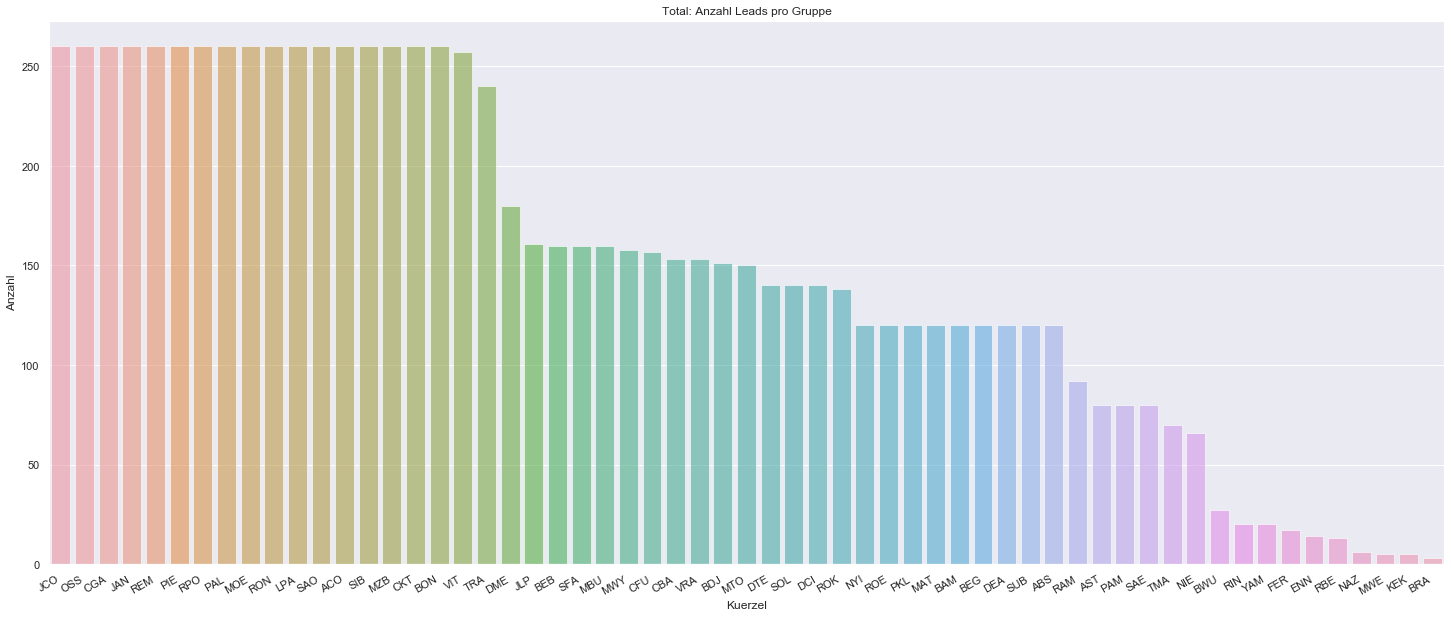

In [13]:
sns.set(style="darkgrid")
plt.figure(figsize=(25,10))
ax = (
    sns.countplot(
        x     = "Kuerzel",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )
    
plt.title("Total: Anzahl Leads pro Gruppe")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Kuerzel")
plt.ylabel("Anzahl")

Text(84.5, 0.5, 'Kuerzel')

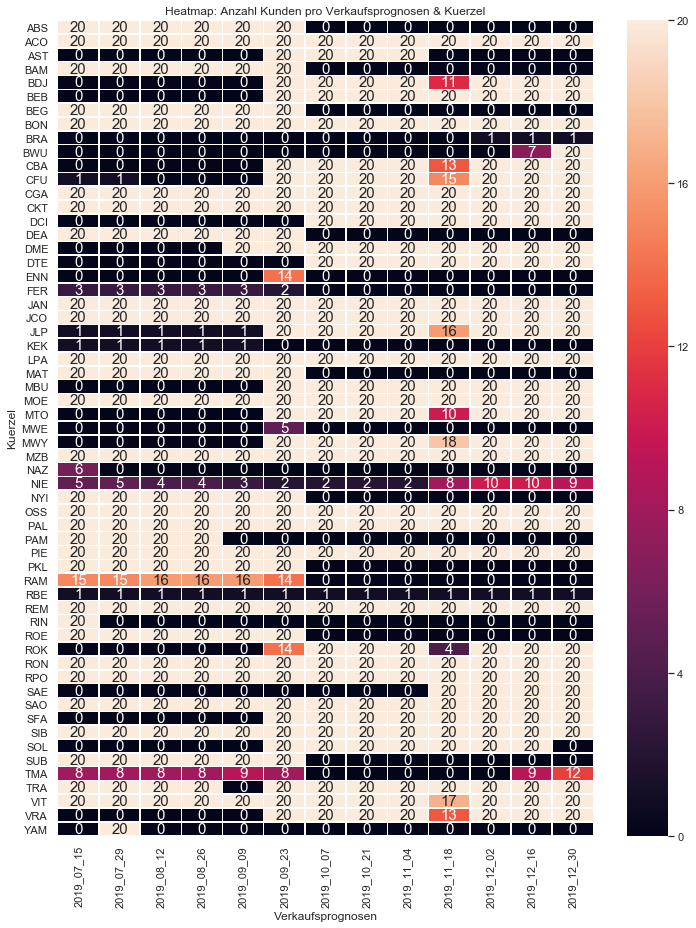

In [14]:
heatmap_data = pd.pivot_table(
    raw_feedback,
    index      = "folder",
    columns    = "Kuerzel",
    values     = "Endkunde_NR",
    aggfunc    = np.count_nonzero,
    fill_value = 0
    ).T

plt.figure(figsize=(12,15))

ax = sns.heatmap(
    data       = heatmap_data,
    linewidths = 0.5,
    annot      = True,
    annot_kws={"size": 15},
    )

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Heatmap: Anzahl Kunden pro Verkaufsprognosen & Kuerzel")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Kuerzel")